<a href="https://colab.research.google.com/github/BoHye0202/Toy-Project/blob/main/4.Autonomous%20driving/Autonomous_driving.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 데이터 수집
1. BDD 100K
  - 가상 주행 장면에 대한 다양한 대규모 dataset
  - UC 버클리에서 제공하는 오픈 소스 데이터셋
  - 주석 처리된 10만 개 이상의 다양한 비디오 클립에 주행장면의 가장 큰 데이터셋이며 주석이 달려있다.
  - 40초의 비디오 시퀀스, 720픽셀 해상도, 초당 30 프레임 고화질로 취득된 100,000개 비디오 시퀀스로 구성된다.
  - 이미지 태그 지정, 차선 감지, 주행 영역 분할(drivable area segmentation), 도로 객체 감지, 이미지 분할(segmantic image segmentation), 인스턴스 분할(instance segementation), 다중 객체 감지 추적, 다중 객체 분할 추적, 도메인 적응 및 모방 학습의 10가지 작업을 수행할 수 있다.
  - https://bdd-data.berkeley.edu/portal.html#download
  - https://github.com/bdd100k/bdd100k

2. nuScenes
  - 자율주행을 위한 멀티모달 데이터셋
  - 실제 자율주행 자동차의 센서 세트를 장착해 실험적으로 도시주행 상황을 연구하여 얻은 데이터셋
  - 1000개의 장면으로 구성되어 있으며 각 장면의 길이는 20초이고 23개 클래스와 8개 속성에 대해 3D 바운딩박스로 주석을 달았다.

3. AppoloScape
  - Baidu에서 제공하는 데이터셋
  - https://www.techleer.com/articles/502-presenting-apollo-scape-by-baidu-a-dataset-that-is-possibly-the-worlds-largest-for-autonomous-driving/ 

4. kitti 데이터셋
  - http://www.cvlibs.net/datasets/kitti/
  
5. COCO
  - https://cocodataset.org/#explore



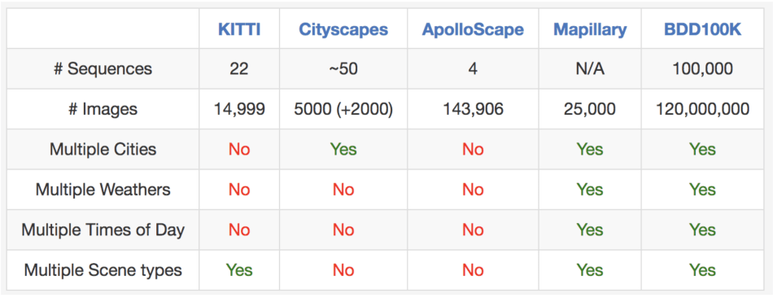

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7230061793587718110, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10255898327938281566
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

# 2. 데이터 선정 및 그 이유
 자율주행을 위한 데이터는 생각보다 많았다. 다음과 같은 자율주행 코드구현을 위해 필요한 데이터들은 다음과 같이 수집할 수 있었다. 나는 그 중 가장 많은 데이터를 제공하는 BDD 100K 데이터를 활용하기로 했다.

- Images Data: 100K의 비디오를 제공하나 용량이 너무 커서 내 노트북에서는 감당할 수 없기 때문에 Image 데이터 10K개를 활용했다.
  ```
  - bdd100k
      - images
          - 100k
              - train
              - val
              - test
          - 10k
              - train
              - val
              - test
  ```
- Labels: Annotations of road objects, lanes, and drivable areas in JSON format released in 2018. Details at Github repo.

### ADAS와 자율주행
Object Detection의 대표적인 활용분야는 자동차이다. 최근 자율주행 자동차에 대한 관심도 높아지고 있고 최근 나오는 신차들을 보면 대부분 ADAS(Advanced Driver Assistance System)라는 운전자 보조 시스템을 탑재하여 출시되고 있습니다.
ADAS는 자율주행 Level 0~2.5단계 과정을 의미하며 그 이상은 부분/완전 자율주행이다.
다른 Object Detection 사례에서도 중요하겠지만 특히 자동차에서 중요하게 여거지는 점은 False Neagetive 즉 객체가 존재하지만 인식하지 못하는 경우를 최소화해야한다.
만약에 보행자가 존재하는데 몇 만분의 1확률로 이를 놓친다면 바로 인명사고로 이어질 가능성이 높기 때문이다.
또한 자동차 내부의 탑재된 Embedded Device에서 수행이 되어야해서 컴퓨팅 파워가 보장되는 고사양의 서버환경이 아니기 때문에 연산량이 큰 모델을 사용하기 어렵습니다. 그러므로 굉장히 어려운 적용 사례 중에 하나이며 많은 연구가 진행이 되고 있습니다.

In [ ]:
# !pip install numpy==1.13.3

In [ ]:
import pandas as pd
import numpy as np
import cv2, torch
import os, time, random
import tensorflow as tf
from tqdm.auto import tqdm
import shutil as sh
import matplotlib.image as mpimg

from IPython.display import Image, clear_output
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
%matplotlib inline

# 3. Data-driven thinking / decision
자율주행 자동차를 구현하기 위해서는 SW와 HW지식을 기반으로 AI 모델을 구현하고 HW(자동차)를 제어해야 한다. 이번 프로젝트에서 아두이노나 ATMega 등 RC카를 활용해서 HW적인 부분까지 함께 구현하면 더 좋겠으나 일단 2D 이미지를 가지고 Object Dectection을 하고자 한다.

### SW
- Camera & Line detecting (OpenCV Library 활용)
- Determine Car Action Model (Tensorflow CNN - MNN)
- Control RC car (Raspberrypi GPIO with Motor Drive)

### HW
- Motors for driving
- USB camera module for get line image
- Motor shield(L298N) for control motor
- Raspberrypi for Input data

### Process
1. Image PreProcessing
  - Harr-casacade Detection
2. DNN Object Detection (Baselilne Model)
3. YOLO Object Detection
  - 도로 위 사물인식
  - 차선 인식
  - 표지판 인식
  - 차량 추적
    - 앞 차량을 추적하는 Traking기법. 앞차와 거리에 따라 속도를 조절하는 Adqptive Curise Control 기버을 구현
  - 앞차와 거리유지

###
Ch1. 도로 표지판 인식 프로젝트
　01. 딥러닝 프로젝트 소개
　02. YOLO 학습 프로젝트 소개
　03. 이미지 레이블링
　04. YOLO 데이터 포멧
　05. YOLO 학습 준비하기
　06. 다크넷 프레임워크 사용하기
　07. 다크넷으로 YOLO 사용하기
　08. 다크넷으로 모델 학습하기
　09. 다크넷으로 학습한 모델 사용하기
　10. 도로 표지판 데이터셋 변환
　11. 도로 표지판 학습 준비하기
　12. 표지판 인식 프로그램 제작
　13. 표지판 인식 프로그램 테스트
　14. Detection을 위한 표지판 학습 준비하기
　15. 도로 표지판 인식 프로그램 테스트하기

Ch2. 도로 차량 추적 프로젝트
　01. 다크넷 클론으로 YOLO사용하기
　02. DeepDrive 영상에서 차량 식별하기
　03. 영상을 저장하여 끊임없이 보는 방법
　04. 영상에 차선 표시하기
　05. ROI를 조정해서 차선 인식률을 높이기
　06. 원하는 물체와 앞에 달리는 차량 식별하기
　07. Detection과 Tracking 기법
　08. Tracking 기법으로 앞차 추적하기
　09. 다양한 Tracking 기법 비교하기
　10. 앞차와 거리변화를 측정하는 프로그램 제작
　11. 앞차와 거리변화에 따라 속도조정 테스트하기
　12. 딥러닝 프로젝트 정리

# 4. Data Load

In [ ]:
train_url = '/content/drive/MyDrive/Colab_Notebooks/10k/train'
val_url = '/content/drive/MyDrive/Colab_Notebooks/10k/val'
test_url = '/content/drive/MyDrive/Colab_Notebooks/10k/test'

a = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/10k/train/0004a4c0-d4dff0ad.jpg')
b = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/10k/train/002bf392-acddbad2.jpg')
c = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/10k/train/8016a78e-1d969047.jpg')
print(a.shape, b.shape)

(720, 1280, 3) (720, 1280, 3)


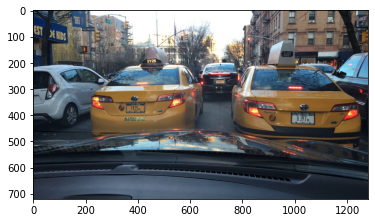

In [ ]:
plt.imshow(a[:,:,::-1])

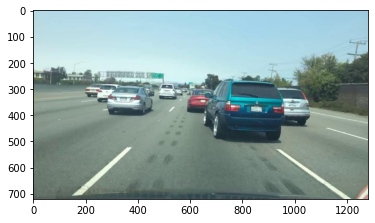

In [ ]:
plt.imshow(b[:,:,::-1])

In [ ]:
img_h, img_w, num_channels = 720, 1280, 3
train_path = os.listdir(train_url)
val_path = os.listdir(val_url)

print(len(train_path), len(val_path))

7004 1000


# 5. Data PreProcessing


## Camera Calibration
- 카메라 왜곡을 보정하는 과정으로 크게 Radial Distortion과 Tangential Distortion 이 생긴다.
1. 경계선 검출
2. Hough Transform (허프변환)을 통한 직선 검출

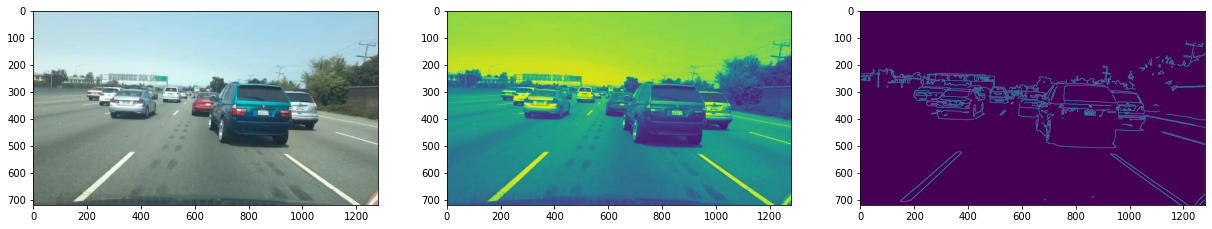

In [ ]:
def grayscale(img): #흑백이미지로 변환
  return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gaussian_blur(img, kernel_size): # 가우시안 필터
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def canny(img, low_threshold, high_threshold): # Canny- 경계선 검출
    return cv2.Canny(img, low_threshold, high_threshold)

image = b
gray_img = grayscale(image)
blur_img = gaussian_blur(gray_img, 3)
canny_img = canny(blur_img, 70, 210)

fig = plt.figure(figsize=(21,10))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.imshow(image[:,:,::-1])
ax2.imshow(gray_img)
ax3.imshow(canny_img)

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


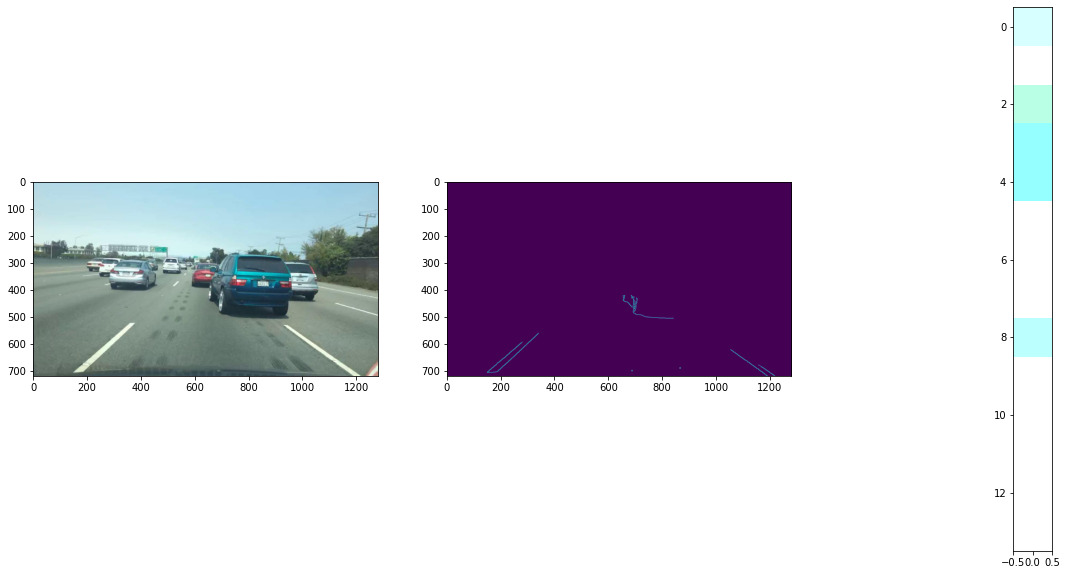

In [ ]:
def region_of_interest(img, vertices, color3=(255,255,255), color1=255): # ROI 셋팅

    mask = np.zeros_like(img) # mask = img와 같은 크기의 빈 이미지
    
    if len(img.shape) > 2: # Color 이미지(3채널)라면 :
        color = color3
    else: # 흑백 이미지(1채널)라면 :
        color = color1
        
    # vertices에 정한 점들로 이뤄진 다각형부분(ROI 설정부분)을 color로 채움 
    cv2.fillPoly(mask, vertices, color)
    
    # 이미지와 color로 채워진 ROI를 합침
    ROI_image = cv2.bitwise_and(img, mask)
    return ROI_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):  # 허프 변환
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    # line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    # draw_lines(line_img, lines)
    return lines

vertices = np.array([[(50,img_h),(img_w/2-45, img_h/2+60), (img_w/2+45, img_h/2+60), (img_w-50,img_h)]], dtype=np.int32)
ROI_img = region_of_interest(canny_img, vertices) # ROI 설정

line_arr = hough_lines(ROI_img, 1, 1 * np.pi/180, 30, 10, 20) # 허프 변환
line_array = np.squeeze(line_arr)

fig = plt.figure(figsize=(21,10))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1.imshow(image[:,:,::-1])
ax2.imshow(ROI_img)
ax3.imshow(line_arr)

plt.show()

(5, 1, 4) (4, 1, 4)


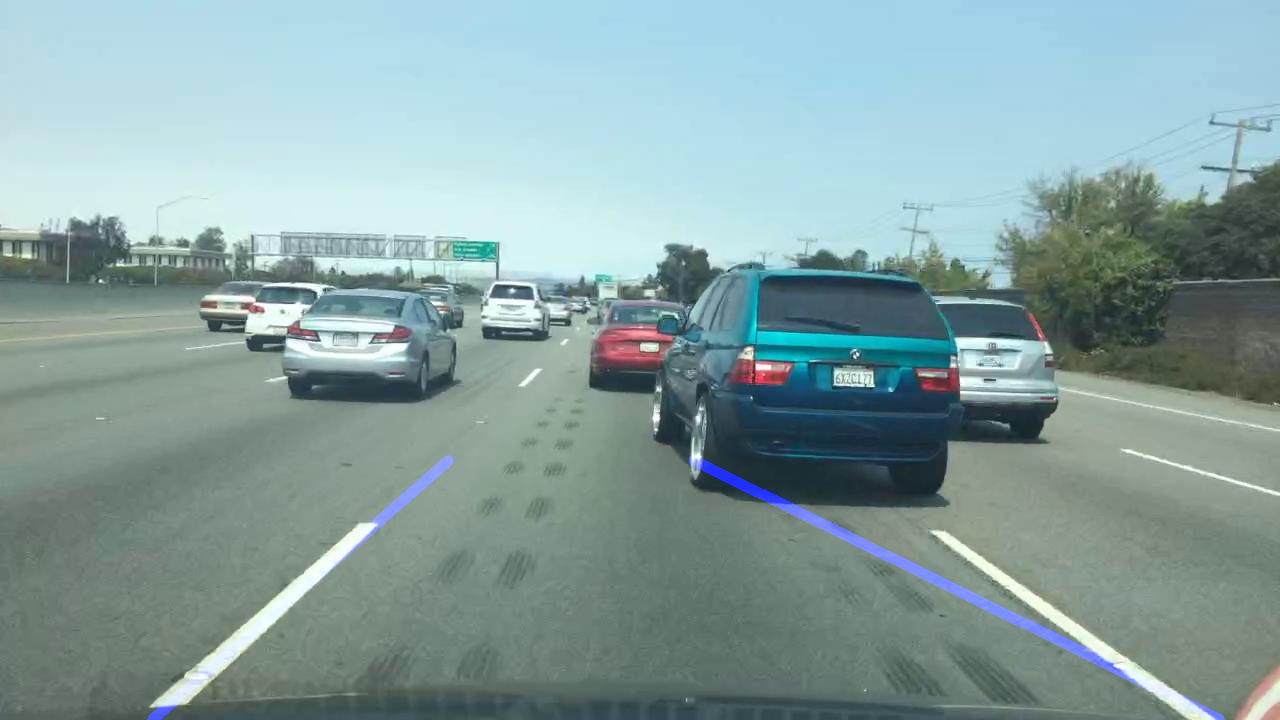

In [ ]:
def weighted_img(img, initial_img, α=1, β=1., λ=0.):  # 두 이미지 operlap 하기
    return cv2.addWeighted(initial_img, α, img, β, λ)

def get_fitline(img, f_lines):  # 대표선 구하기
    lines = np.squeeze(f_lines)
    lines = lines.reshape(lines.shape[0] * 2, 2)
    rows, cols = img.shape[:2]
    output = cv2.fitLine(lines, cv2.DIST_L2, 0, 0.01, 0.01)
    vx, vy, x, y = output[0], output[1], output[2], output[3]
    x1, y1 = int(((img.shape[0] - 1) - y) / vy * vx + x), img.shape[0] - 1
    x2, y2 = int(((img.shape[0] / 2 + 100) - y) / vy * vx + x), int(img.shape[0] / 2 + 100)

    result = [x1, y1, x2, y2]
    return result

# 기울기 구하기
slope_degree = (np.arctan2(line_array[:,1] - line_array[:,3], line_array[:,0] - line_array[:,2]) * 180) / np.pi

# 수평 기울기 제한
line_array = line_array[np.abs(slope_degree)<160]
slope_degree = slope_degree[np.abs(slope_degree)<160]
# 수직 기울기 제한
line_array = line_array[np.abs(slope_degree)>95]
slope_degree = slope_degree[np.abs(slope_degree)>95]
# 필터링된 직선 버리기
L_lines, R_lines = line_array[(slope_degree>0),:], line_array[(slope_degree<0),:]

temp = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
L_lines, R_lines = L_lines[:,None], R_lines[:,None]
print(L_lines.shape, R_lines.shape)

# 왼쪽, 오른쪽 각각 대표선 구하기
left_fit_line = get_fitline(image,L_lines)
right_fit_line = get_fitline(image,R_lines)

# 대표선 그리기
draw_fit_line(temp, left_fit_line)
draw_fit_line(temp, right_fit_line)

result = weighted_img(temp, image) # 원본 이미지에 검출된 선 overlap
cv2_imshow(result) # 결과 이미지 출력

## 경계선 검출(Canny Edge)

In [ ]:
img_h, img_w, num_channels = 720, 1280, 3

def grayscale(img): #흑백이미지로 변환
  return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def gaussian_blur(img, kernel_size): # 가우시안 필터
    return cv2.GaussianBlur(img, (kernel_size, kernel_size),10)

def canny(img, low_threshold, high_threshold): # Canny- 경계선 검출
    return cv2.Canny(img, low_threshold, high_threshold)

canny_images = []
for fname in train_path:
  img = mpimg.imread(train_url+'/'+fname)

  gray_img = grayscale(img)
  blur_img = gaussian_blur(gray_img, 3)
  canny_img = canny(blur_img, 70, 210)
  canny_images.append(canny_img)

## 직선 검출 (Hough Transform 이용)

In [ ]:
def region_of_interest(img, vertices, color3=(255,255,255), color1=255): # ROI 셋팅
    mask = np.zeros_like(img) # mask = img와 같은 크기의 빈 이미지
    
    if len(img.shape) > 2: # Color 이미지(3채널)라면 :
        color = color3
    else: # 흑백 이미지(1채널)라면 :
        color = color1
        
    # vertices에 정한 점들로 이뤄진 다각형부분(ROI 설정부분)을 color로 채움 
    cv2.fillPoly(mask, vertices, color)
    
    # 이미지와 color로 채워진 ROI를 합침
    ROI_image = cv2.bitwise_and(img, mask)
    return ROI_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):  # 선 그리기
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):  # 허프 변환
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    # line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    # draw_lines(line_img, lines)
    return lines

In [ ]:
def weighted_img(img, initial_img, α=1, β=1., λ=0.):  # 두 이미지 operlap 하기
    return cv2.addWeighted(initial_img, α, img, β, λ)

def get_fitline(img, f_lines):  # 대표선 구하기
    if f_lines.shape[0]!=1:
      lines = np.squeeze(f_lines)
    else:
      lines = f_lines
    
    lines = lines.reshape(lines.shape[0] * 2, 2)
    rows, cols = img.shape[:2]
    output = cv2.fitLine(lines, cv2.DIST_L2, 0, 0.01, 0.01)
    vx, vy, x, y = output[0], output[1], output[2], output[3]
    x1, y1 = int(((img.shape[0] - 1) - y) / vy * vx + x), img.shape[0] - 1
    x2, y2 = int(((img.shape[0] / 2 + 100) - y) / vy * vx + x), int(img.shape[0] / 2 + 100)

    result = [x1, y1, x2, y2]
    return result

def draw_fit_line(img, lines, color=[255, 0, 0], thickness=10):  # 대표선 그리기
    cv2.line(img, (lines[0], lines[1]), (lines[2], lines[3]), color, thickness)

## Train / Valid

In [ ]:
for fname in train_path:
  image = mpimg.imread(train_url+'/'+fname)

  gray_img = grayscale(image)
  blur_img = gaussian_blur(gray_img, 3)
  canny_img = canny(blur_img, 70, 210)

  vertices = np.array([[(50,img_h),(img_w/2-45, img_h/2+60), (img_w/2+45, img_h/2+60), (img_w-50,img_h)]], dtype=np.int32)
  ROI_img = region_of_interest(canny_img, vertices) # ROI 설정

  line_arr = hough_lines(ROI_img, 1, 1 * np.pi/180, 30, 10, 20) # 허프 변환
  line_arr = np.squeeze(line_arr)
  
  if not line_arr.any():
    cv2.imwrite('/content/drive/MyDrive/Colab_Notebooks/train/%s.jpg'%fname, image)

  else:
    if line_arr.ndim==1:
      line_arr = line_arr.reshape(1,-1)

    # 기울기 구하기
    slope_degree = (np.arctan2(line_arr[:,1] - line_arr[:,3], line_arr[:,0] - line_arr[:,2]) * 180) / np.pi

    # 수평 기울기 제한
    line_arr = line_arr[np.abs(slope_degree)<160]
    slope_degree = slope_degree[np.abs(slope_degree)<160]

    # 수직 기울기 제한
    line_arr = line_arr[np.abs(slope_degree)>95]
    slope_degree = slope_degree[np.abs(slope_degree)>95]

    # 필터링된 직선 버리기
    L_lines, R_lines = line_arr[(slope_degree>0),:], line_arr[(slope_degree<0),:]
    temp = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    L_lines, R_lines = L_lines[:,None], R_lines[:,None]

    # 왼쪽, 오른쪽 각각 대표선 구하기
    if L_lines.shape[0]!=0:
      left_fit_line = get_fitline(image, L_lines)
    if R_lines.shape[0]!=0:
      right_fit_line = get_fitline(image, R_lines)

    # 대표선 그리기
    if left_fit_line != False:
      draw_fit_line(temp, left_fit_line)
    if right_fit_line != False:
      draw_fit_line(temp, right_fit_line)

    result = weighted_img(temp, image) # 원본 이미지에 검출된 선 overlap
    cv2.imwrite('/content/drive/MyDrive/Colab_Notebooks/train/%s.jpg'%fname, result)

In [ ]:
for fname in val_path:
  image = mpimg.imread(val_url+'/'+fname)

  gray_img = grayscale(image)
  blur_img = gaussian_blur(gray_img, 3)
  canny_img = canny(blur_img, 70, 210)

  vertices = np.array([[(50,img_h),(img_w/2-45, img_h/2+60), (img_w/2+45, img_h/2+60), (img_w-50,img_h)]], dtype=np.int32)
  ROI_img = region_of_interest(canny_img, vertices) # ROI 설정

  line_arr = hough_lines(ROI_img, 1, 1 * np.pi/180, 30, 10, 20) # 허프 변환
  line_arr = np.squeeze(line_arr)
  
  if not line_arr.any():
    cv2.imwrite('/content/drive/MyDrive/Colab_Notebooks/validation/%s.jpg'%fname, image)

  else:
    if line_arr.ndim==1:
      line_arr = line_arr.reshape(1,-1)

    # 기울기 구하기
    slope_degree = (np.arctan2(line_arr[:,1] - line_arr[:,3], line_arr[:,0] - line_arr[:,2]) * 180) / np.pi

    # 수평 기울기 제한
    line_arr = line_arr[np.abs(slope_degree)<160]
    slope_degree = slope_degree[np.abs(slope_degree)<160]

    # 수직 기울기 제한
    line_arr = line_arr[np.abs(slope_degree)>95]
    slope_degree = slope_degree[np.abs(slope_degree)>95]

    # 필터링된 직선 버리기
    L_lines, R_lines = line_arr[(slope_degree>0),:], line_arr[(slope_degree<0),:]
    temp = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    L_lines, R_lines = L_lines[:,None], R_lines[:,None]

    # 왼쪽, 오른쪽 각각 대표선 구하기
    if L_lines.shape[0]!=0:
      left_fit_line = get_fitline(image, L_lines)
    if R_lines.shape[0]!=0:
      right_fit_line = get_fitline(image, R_lines)

    # 대표선 그리기
    if left_fit_line != False:
      draw_fit_line(temp, left_fit_line)
    if right_fit_line != False:
      draw_fit_line(temp, right_fit_line)

    result = weighted_img(temp, image) # 원본 이미지에 검출된 선 overlap
    cv2.imwrite('/content/drive/MyDrive/Colab_Notebooks/validation/%s.jpg'%fname, result)

In [ ]:
pre_processing_train_url = '/content/drive/MyDrive/Colab_Notebooks/train'
pre_processing_train = os.listdir(pre_processing_train_url)
pre_processing_val_url = '/content/drive/MyDrive/Colab_Notebooks/validation'
pre_processing_val = os.listdir(pre_processing_val_url)
print(len(pre_processing_train), len(pre_processing_val))

7004 1000


# 6. Training (Lane Detection )
학습시키는 코드

## 6-1 Baseline Model

In [ ]:
train_path = os.listdir(train_url)
val_path = os.listdir(val_url)

x_train = train_path# 원본데이터
y_train = val_path# Pre-Procssing한 이미지
x_val = pre_processing_train
y_val = pre_processing_val

In [ ]:
print(train_path)

['b001a7ce-5cbc6e0b.jpg', '96330f54-9aec2a54.jpg', 'a93af51d-96dae531.jpg', '8016a78e-1d969047.jpg', '8e6b9b3a-47a55c87.jpg', '78a851f4-f0ae3dad.jpg', '7bd0ba24-d898ebc4.jpg', '9948d09e-c031e817.jpg', '96bbfee1-9cf45d08.jpg', 'a58f81f2-78ae959f.jpg', 'a8e536bd-28b4d625.jpg', 'ad62ff26-ef0c923e.jpg', '872b83f1-12137e15.jpg', 'ad0b7d33-16243e40.jpg', '8fc4b3e0-ec2e528f.jpg', '9c74eeb8-1aa96158.jpg', 'a5ec626e-ec81a030.jpg', 'a5266b69-1c634f21.jpg', '7d24a7cd-daeaf356.jpg', '8e3824b8-0728c159.jpg', 'a278206e-e1bcf1bd.jpg', 'a110e9ed-9e1e288a.jpg', 'a822c459-20b67e7f.jpg', '89038771-b2447052.jpg', '916b6d18-46ba3100.jpg', 'ab4796d2-ef74d367.jpg', '7fc69e06-c26e122e.jpg', '9d9ad1ab-d4970a7e.jpg', 'a5242a75-c9f4fb66.jpg', '9e9bbeed-1eaefaa6.jpg', '7d659512-4c88c7c0.jpg', '99a231d3-034f054d.jpg', 'ab0735fb-f491ca69.jpg', '9b080277-8ee695f8.jpg', '8503e27b-35dd625c.jpg', '93260910-96c238d9.jpg', 'a77b52de-f08fb966.jpg', '7faea992-779a5bf9.jpg', '930d5775-70a083a0.jpg', '8e899c30-1e1e4c46.jpg',

In [ ]:
for i in y_val[:20]:
  x = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/validation/'+i)
  cv2_imshow(x)

## 6-2. U-net Model

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH 

# 7. Yolo Model
도로의 객체 감지

In [ ]:
%%time

!git clone https://github.com/ultralytics/yolov5  # clone repo
!pip install -U pycocotools
!pip install -qr yolov5/requirements.txt  # install dependencies
!cp yolov5/requirements.txt ./ # yolo v5의 모델이 담긴 repo를 clone하고, 필요한 라이브러리, 모듈 설치

Cloning into 'yolov5'...
remote: Enumerating objects: 6006, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 6006 (delta 8), reused 5 (delta 2), pack-reused 5979
Receiving objects: 100% (6006/6006), 8.37 MiB | 34.00 MiB/s, done.
Resolving deltas: 100% (4100/4100), done.
Requirement already up-to-date: pycocotools in /usr/local/lib/python3.7/dist-packages (2.0.2)
     |████████████████████████████████| 645kB 19.4MB/s 
CPU times: user 80.8 ms, sys: 273 ms, total: 354 ms
Wall time: 9.31 s


In [ ]:
train_url = '/content/drive/MyDrive/Colab_Notebooks/10k/train'
val_url = '/content/drive/MyDrive/Colab_Notebooks/10k/val'
test_url = '/content/drive/MyDrive/Colab_Notebooks/10k/test'

In [ ]:
source = 'train'
if True:
    for fold in [0]:
        val_index = train_path[len(train_path)*fold//5:len(train_path)*(fold+1)//5]
        for name,mini in tqdm(df.groupby('image_id')):
            if name in val_index:
                path2save = 'val2017/'
            else:
                path2save = 'train2017/'
            if not os.path.exists('/tmp/convertor/fold{}/labels/'.format(fold)+path2save):
                os.makedirs('/tmp/convertor/fold{}/labels/'.format(fold)+path2save)
            with open('/tmp/convertor/fold{}/labels/'.format(fold)+path2save+name+".txt", 'w+') as f:
                row = mini[['classes','x_center','y_center','w','h']].astype(float).values
                row = row.astype(str)
                for j in range(len(row)):
                    text = ' '.join(row[j])
                    f.write(text)
                    f.write("\n")
            if not os.path.exists('/tmp/convertor/fold{}/images/{}'.format(fold,path2save)):
                os.makedirs('/tmp/convertor/fold{}/images/{}'.format(fold,path2save))
            sh.copy("/content/drive/MyDrive/Colab_Notebooks/10k/{}/{}.jpg".format(source,name),'/tmp/convertor/fold{}/images/{}/{}.jpg'.format(fold,path2save,name))

NameError: ignored

# 8. Requirements.txt
내가 만든 딥러닝 모델을 단 한번만 사용하지 않을 것이기 때문에 모델을 저장하고, 또 새로운 환경에서 바로 구현할 수 있도록 Requirements.txt를 만들어보자.
언제까지 colab만 쓸 수 없기 때문이다.

# 수행 작업
1. 도로 객체 감지
2. 인스턴스 세그먼테이션
3. 운전 가능 지역
4. 차선 구분
5. 시멘틱 세그먼테이션 

In [ ]:
img_h, img_w, num_channels = 720, 1280, 3

train_path = []
file_list = os.listdir(train_url)
for i in file_list:
  file_list_jpg = [i+'/'+file for file in file_list if file.endswith(".jpg")]
  train_path += file_list_jpg
print(len(train_path))

val_path = []
file_list = os.listdir(val_url)
for i in file_list:
  file_list_jpg = [i+'/'+file for file in file_list if file.endswith(".jpg")]
  val_path += file_list_jpg
print(len(val_path))

49056016
1000000


In [ ]:
train = []
for i in train_path:
  img = cv2.imread(i)
  tmp = np.array(img) # image를 numpy array로 변경
  tmp_nor = (tmp-127.5)/127.5 # normalization
  tmp = tf.constant(img_nor) #numpy array를 tensor로 변경
  train.append(tmp)
print(len(train))

val = []
for i in val_path:
  img = cv2.imread(i)
  tmp = np.array(img) # image를 numpy array로 변경
  tmp_nor = (tmp-127.5)/127.5 # normalization
  tmp = tf.constant(img_nor) #numpy array를 tensor로 변경
  val.append(tmp)
print(len(val))

TypeError: ignored

In [ ]:
# Array to store object points and image points from all the images

objpoints = []  # 3D points in real world space
imgpoints = []  # 2D points in image plane

def calib():
    """
    To get an undistorted image, we need camera matrix & distortion coefficient
    Calculate them with 9*6 20 chessboard images
    """
    # Prepare object points
    objp = np.zeros((6 * 9, 3), np.float32)
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)  # x,y coordinates

    for fname in train_path:

        img = mpimg.imread(train_url+'/'+fname)
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

        # If corners are found, add object points, image points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
        else:
            continue

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return mtx, dist

def undistort(img, mtx, dist):
    """ undistort image """
    return cv2.undistort(img, mtx, dist, None, mtx)

mtx, dist = calib()
undist_img = undistort(a, mtx, dist)
plt.imshow(a[:,:,::-1])

error: ignored